# Домашнее задание. Решение конкурса на kaggle.com

Это домашнее задание посвящено полноценному решению задачи машинного обучения.

# Описание задания 

Требуется научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы. На станице с данными два файла - train.csv (содержит колонки признаков и целевую переменную) и test.csv (содержит только колонки признаков). В качестве ответа вам необходимо загрузить предсказания вероятностей ухода клиентов для test.csv. Пример файла с предскзааниями - submission.csv.

## Описание данных

* ClientPeriod – период, который клиент уже использует услуги компании (в месяцах).
* MonthlySpending – ежемесячные траты клиента на услуги компании.
* TotalSpent – общие траты клиента за всё время использования услуг.
* Sex – пол клиента.
* IsSeniorCitizen – является ли клиент пожилым человеком (1 – да, 0 – нет).
* HasPartner – наличие партнера у клиента (Yes/No).
* HasChild – есть ли у клиента дети (Yes/No).
* HasPhoneService – подключена ли телефонная связь (Yes/No).
* HasMultiplePhoneNumbers – наличие нескольких телефонных номеров (Yes/No).
* HasInternetService – подключена ли интернет-услуга (Yes/No).
* HasOnlineSecurityService – есть ли онлайн-защита (Yes/No).
* HasOnlineBackup – использует ли клиент онлайн-резервное копирование (Yes/No).
* HasDeviceProtection – подключена ли защита устройств (Yes/No).
* HasTechSupportAccess – имеет ли клиент доступ к технической поддержке (Yes/No).
* HasOnlineTV – использует ли клиент онлайн-телевидение (Yes/No).
* HasMovieSubscription – подключена ли подписка на фильмы (Yes/No).
* HasContractPhone – есть ли контракт на мобильный телефон (Yes/No).
* IsBillingPaperless – бумажная или электронная система оплаты счетов (Yes/No).
* PaymentMethod – метод оплаты (например, кредитная карта, автоматическое списание и т.д.).
* Churn – целевая переменная, обозначающая факт ухода клиента (1 – ушел, 0 – остался).

## Импорт необходимых библиотек

In [157]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc


warnings.filterwarnings("ignore")

## Загрузка данных

1) Посмотрим на случайные строчки.

2) Посмотрим, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, заменим их на что-нибудь.

### Общая загрузка данных и информация

In [123]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /Users/daniilsergeev/Downloads/train.csv
100%|█████████████████████████████████████████| 664k/664k [00:01<00:00, 480kB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /Users/daniilsergeev/Downloads/test.csv
100%|█████████████████████████████████████████| 218k/218k [00:00<00:00, 674kB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /Users/daniilsergeev/Downloads/submission.csv
100%|███████████████████████████████████████| 14.7k/14.7k [00:00<00:00, 959kB/s]


In [124]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

In [125]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

**Информация о датасете**

In [126]:
display(train.sample(5))
print()
display(test.sample(5))

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1886,1,55.00,55,Female,0,No,No,Yes,No,DSL,No,No,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),1
1836,19,96.80,1743.05,Female,0,Yes,No,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
1902,47,80.35,3825.85,Female,1,Yes,No,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Electronic check,1
563,37,45.40,1593.1,Female,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,Two year,No,Electronic check,0
2735,26,20.30,511.25,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,0


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
409,19,20.15,387.7,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
563,20,19.70,406.95,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
218,28,59.55,1646.45,Female,0,No,No,Yes,No,DSL,No,No,Yes,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic)
1300,14,78.95,1101.85,Female,1,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1713,2,46.60,87.9,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic)


In [127]:
train.info()
print('-----------------------------------------------------------')
test.info()
print('-----------------------------------------------------------')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

### Предобработка данных
1) Проверим датасет на наличие пропусков;
2) Проверим датасет на наличие дубликатов;
3) Изменим тип данных в столбце TotalSpent с object на float64.

**Пропуски**

In [128]:
# Проверка на наличие пропусков в train
nan_table = pd.DataFrame({
    'NaN_Count': train.isna().sum()
})

display(nan_table)

,NaN_Count
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


In [129]:
# Проверка на наличие пропусков в test
nan_table = pd.DataFrame({
    'NaN_Count': test.isna().sum()
})

display(nan_table)

,NaN_Count
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


In [130]:
# Проверка на наличие пропусков в submission
nan_table = pd.DataFrame({
    'NaN_Count': submission.isna().sum()
})

display(nan_table)

,NaN_Count
Id,0
Churn,0


Пропусков не обнаружено.

**Дубликаты**

In [131]:
duplicates = train.duplicated()

# Считаем количество дубликатов
num_duplicates = duplicates.sum()
print(f'Количество дубликатов в train: {num_duplicates}')

Количество дубликатов в train: 14


In [132]:
duplicates = test.duplicated()

# Считаем количество дубликатов
num_duplicates = duplicates.sum()
print(f'Количество дубликатов в test: {num_duplicates}')

Количество дубликатов в test: 3


In [133]:
duplicates = submission.duplicated()

# Считаем количество дубликатов
num_duplicates = duplicates.sum()
print(f'Количество дубликатов в submission: {num_duplicates}')

Количество дубликатов в submission: 0


Уберём дубликаты только в train. Дубликаты в test оставим, тк иначе повлияем на размерность.

In [134]:
train.drop_duplicates(inplace = True)

In [135]:
duplicates = train.duplicated()

# Проверяем наличие дубликатов после удаления
num_duplicates = duplicates.sum()
print(f'Количество дубликатов в train: {num_duplicates}')

Количество дубликатов в train: 0


**Изменение типа данных**

In [136]:
# Изменение типа данных в столбце TotalSpent
train['TotalSpent'] = pd.to_numeric(train['TotalSpent'], errors='coerce')
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'], errors='coerce')

In [137]:
print('Тип данных в столбце TotalSpent после изменений:', train['TotalSpent'].dtype)

Тип данных в столбце TotalSpent после изменений: float64


**Проверим наличие пропусков после изменения типа данных**

In [138]:
print('Количество дубликатов после изменения типа данных в train =', train['TotalSpent'].isna().sum())
print('Количество дубликатов после изменения типа данных в test =', test['TotalSpent'].isna().sum())

Количество дубликатов после изменения типа данных в train = 9
Количество дубликатов после изменения типа данных в test = 2


Изучим эти строки.

In [139]:
display(train[train['TotalSpent'].isna()])
print()
display(test[test['TotalSpent'].isna()])


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,NaN,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


Вместо пропущенных значений вставим 0, тк столбец TotalSpent появляется путём умножения ClientPeriod на MonthlySpending.

In [140]:
train['TotalSpent'].fillna(0, inplace=True)
test['TotalSpent'].fillna(0, inplace=True)

print('Количество пропусков в train[TotalSpent] =', train['TotalSpent'].isna().sum())
print('Количество пропусков в test[TotalSpent] =', test['TotalSpent'].isna().sum())

Количество пропусков в train[TotalSpent] = 0
Количество пропусков в test[TotalSpent] = 0


### Промежуточный вывод по загрузке и предобрабтке данных

Данные были успешно загружены. После загрузки данных было определено:
1. Пропуски в данных отсутствуют;
2. В столбце 'TotalSpent' тип данных object, а должен быть float;
3. Возможно существуют дубликаты.

Далее, была выполнена предобработке данных, где
* Были выявлены и удалены дубликаты в датасете train;
* Изменён тип данных признака 'TotalSpent';
* Заполнены пропуски в признаке 'TotalSpent', появившиеся в связи с изменением типа данных этого столбца, на 0.

## Анализ данных

### Статистический анализ данных

**Посмотрим на данные с помощью метода describe**

In [141]:
display(train.describe())

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000
mean,32.480448,64.977563,2293.445549,0.159643,0.260820
std,24.529439,30.176025,2269.111393,0.366310,0.439124
min,0.000000,18.250000,0.000000,0.000000,0.000000
25%,9.000000,35.537500,401.925000,0.000000,0.000000
50%,29.000000,70.450000,1411.500000,0.000000,0.000000
75%,55.000000,90.050000,3808.637500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


* Средние значения ежемесячных расходов и общей суммы трат, а также высокая доля оттока клиентов (26%), могут сигнализировать о проблеме удержания клиентов. Высокий разброс в общей сумме трат и периоде обслуживания указывает на значительное разнообразие клиентов по их поведению и тратам.
* Большая часть клиентов не является пенсионерами, но из-за наличия оттока стоит провести дальнейший анализ для выявления факторов, влияющих на отток, особенно среди клиентов с высокими расходами или продолжительным обслуживанием.

### Анализ данных на диаграммах

**Анализ числовых признаков**

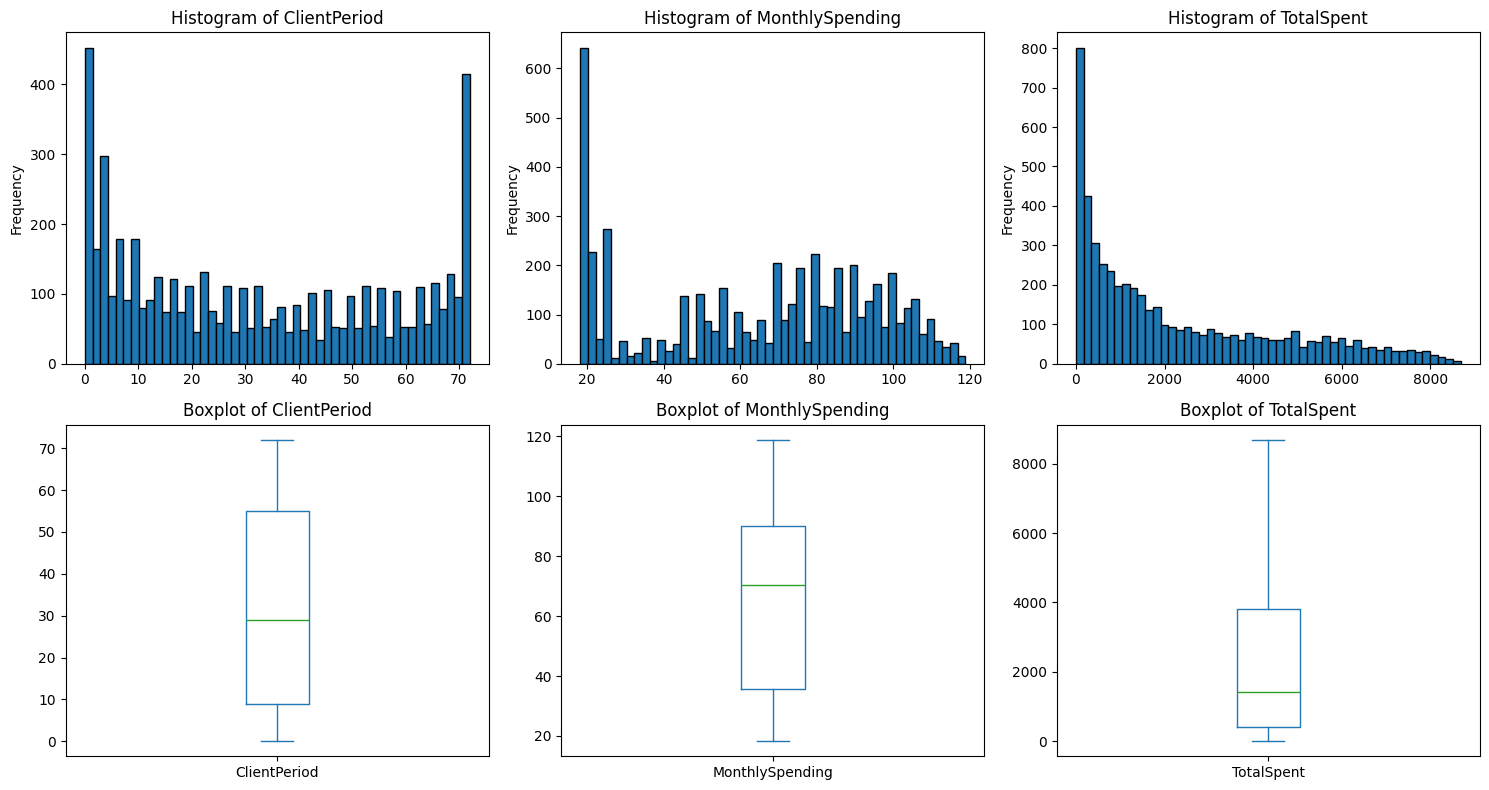

In [142]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Перебираем оси и строим гистограммы на первой строке
for ax, col in zip(axes[0, :], train[num_cols]):
    ax.set_title(f"Histogram of {col}")
    train[col].plot(kind="hist", ec="black", ax=ax, bins=50)

# Строим boxplots на второй строке
for ax, col in zip(axes[1, :], train[num_cols]):
    ax.set_title(f"Boxplot of {col}")
    train[col].plot(kind="box", ax=ax)

# Выравниваем графики
plt.tight_layout()
plt.show()

**1. ClientPeriod (Период обслуживания клиентов):**

* Гистограмма показывает, что большая часть клиентов либо совсем новые (около 0 месяцев обслуживания), либо очень длительное время (70-72 месяца). Это может свидетельствовать о двух основных типах клиентов: новички и лояльные клиенты, которые остаются с компанией в течение длительного периода.
* Boxplot указывает на симметричное распределение данных без явных выбросов. Большинство клиентов обслуживаются в течение 30-40 месяцев, с разбросом до 70 месяцев.

**2. MonthlySpending (Ежемесячные расходы):**

* Гистограмма имеет выраженный пик в районе 20-30 денежных единиц, что указывает на значительное количество клиентов с низкими ежемесячными расходами. После этого виден более равномерный разброс вплоть до 120 денежных единиц.
* Boxplot показывает, что большинство клиентов тратят в пределах 35-90 денежных единиц в месяц. Также нет явных выбросов, что говорит о стабильности трат в этой категории.

**3. TotalSpent (Общая сумма трат):**
* Гистограмма демонстрирует, что значительное количество клиентов имеет очень низкие общие траты (много клиентов с нулевыми тратами или близкими к нулю). Это может быть связано с клиентами, которые недавно подключились или не активно пользовались услугами.
* Boxplot также показывает асимметричное распределение, так как медиана значительно ниже максимальных значений. Это подтверждает, что значительное количество клиентов имеет небольшие общие траты, но есть небольшая группа клиентов с очень высокими затратами (до 8000 денежных единиц).

**Анализ категориальных признаков**

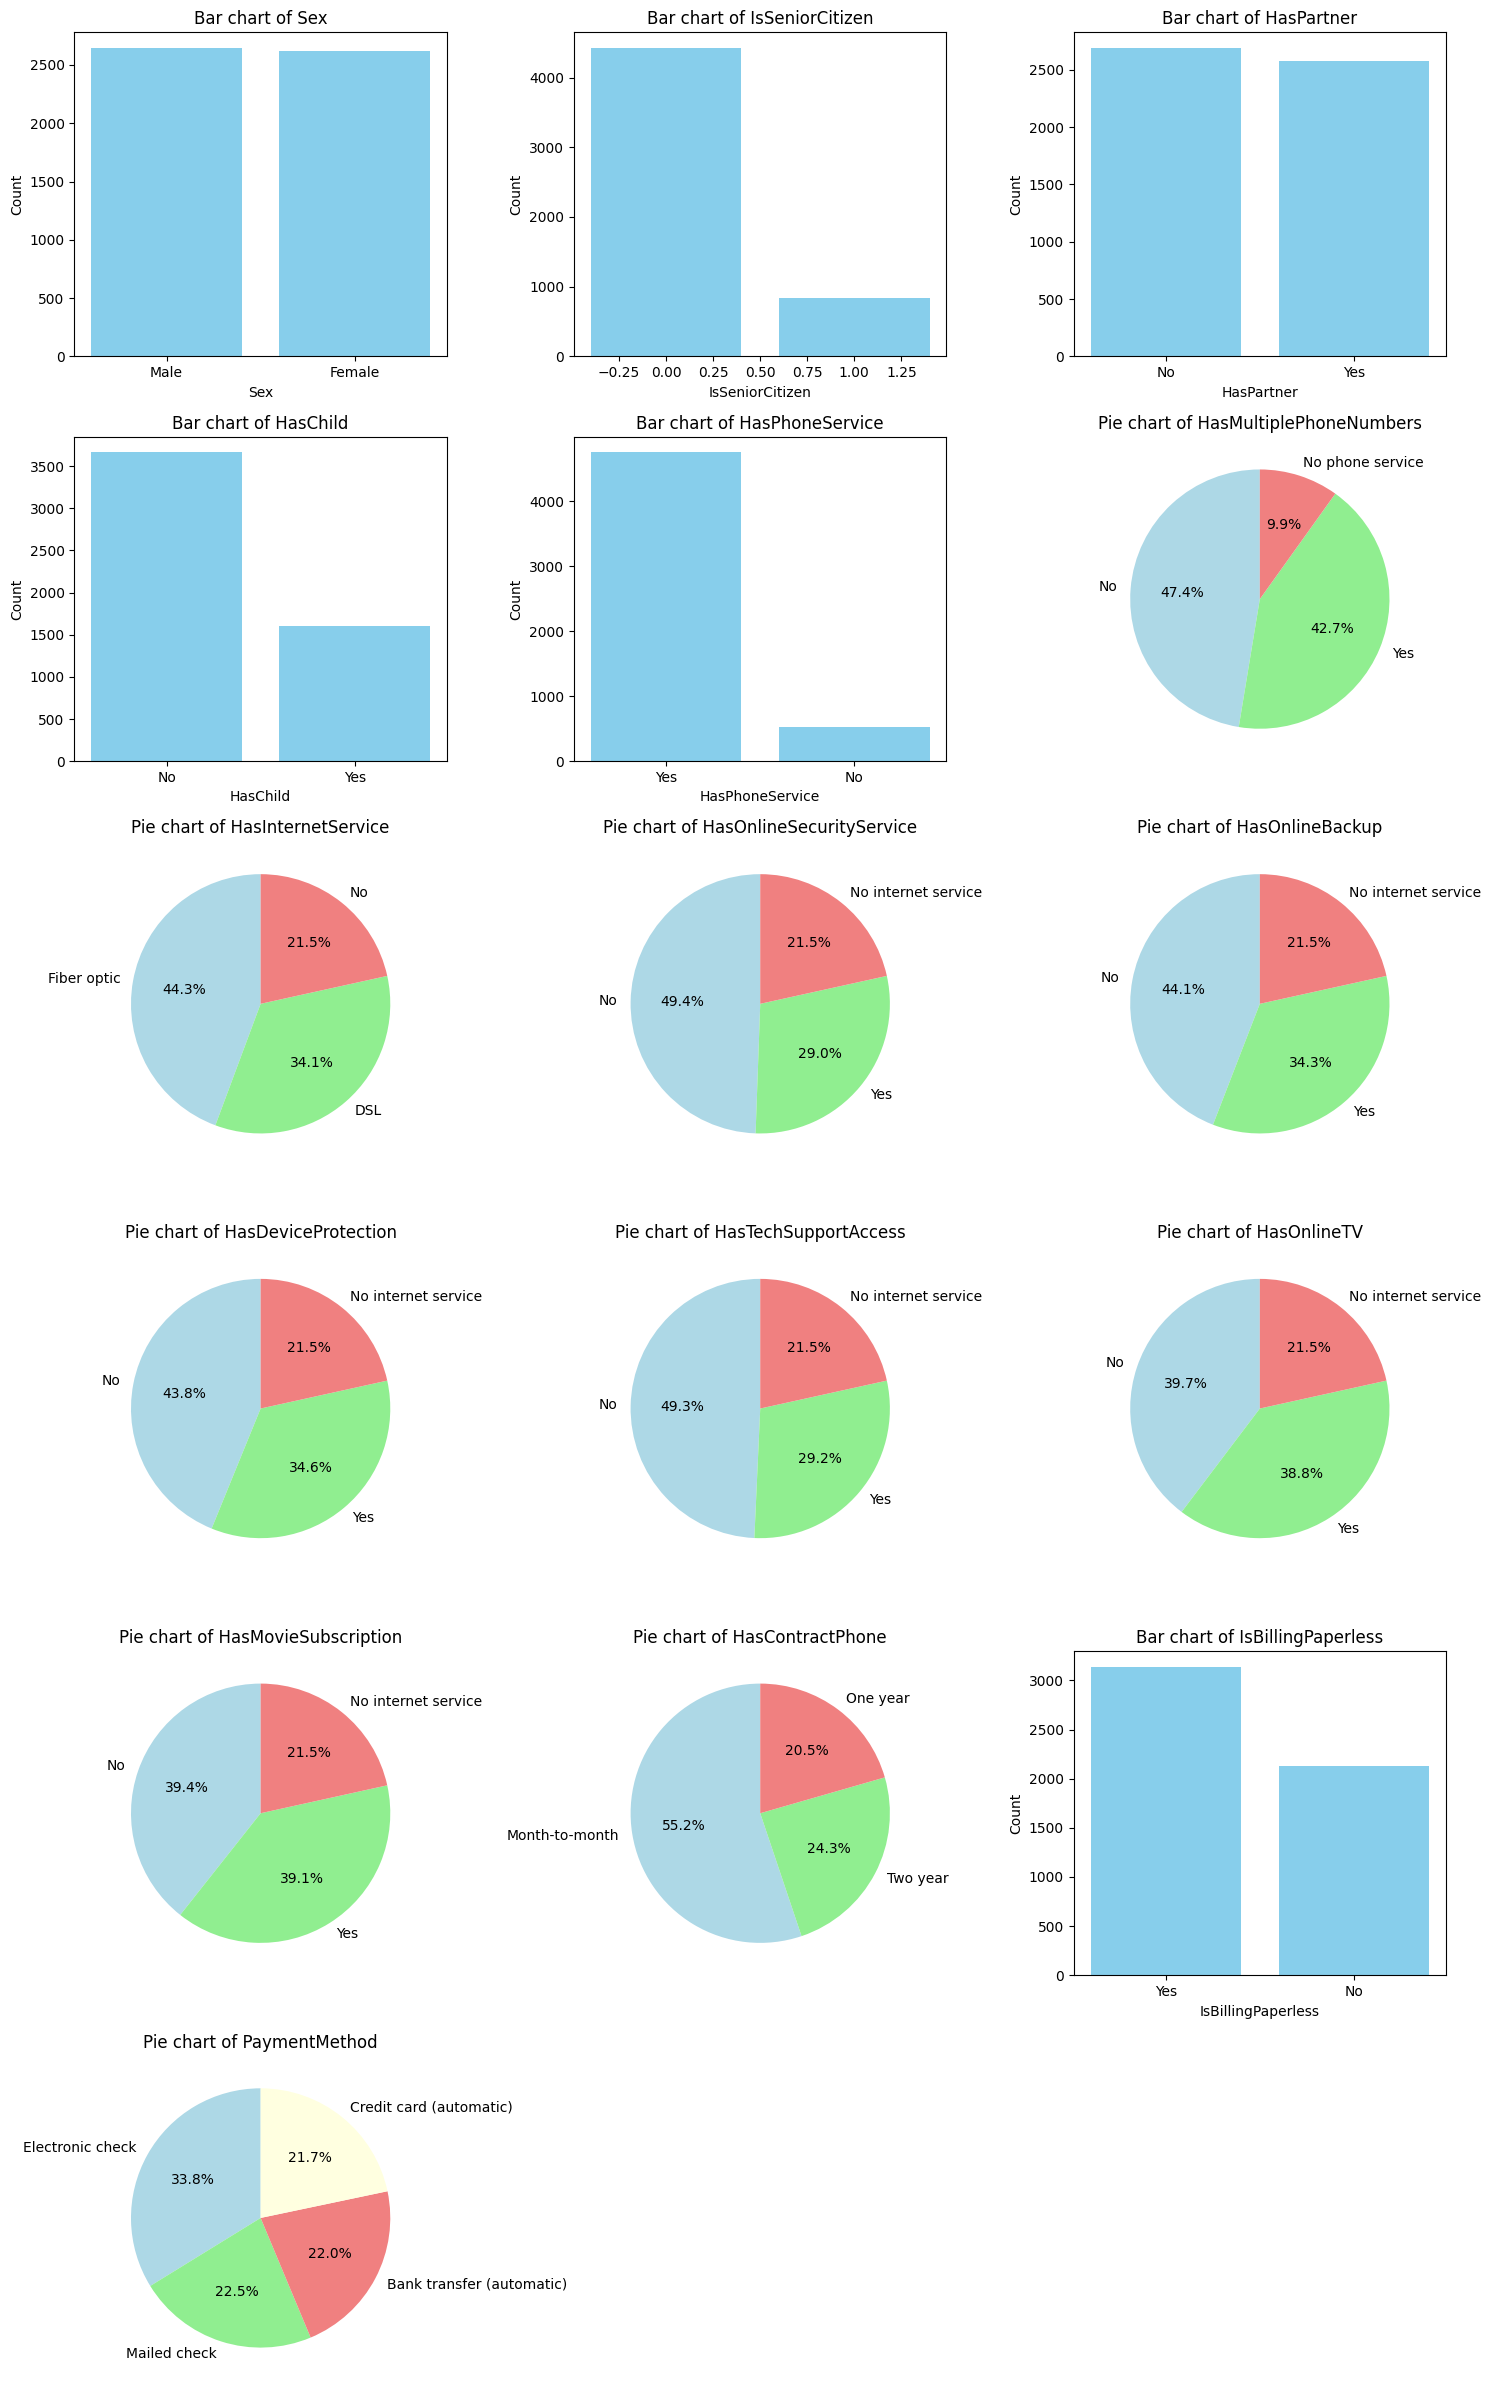

In [143]:
rows = (len(cat_cols) + 2) // 3  # Рассчитываем количество строк для диаграмм
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15, 4 * rows))

# Преобразуем оси в одномерный массив, чтобы обращаться к ним проще
axes = axes.flatten()

# Проходимся по признакам и строим нужные графики
for i, col in enumerate(cat_cols):
    value_counts = train[col].value_counts()
    
    # Если категорий меньше 3, строим bar chart
    if train[col].nunique() < 3:
        axes[i].bar(value_counts.index, value_counts.values, color='skyblue')
        axes[i].set_title(f'Bar chart of {col}')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)
    
    # Если категорий 3 и больше, строим pie chart
    else:
        axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
        axes[i].set_title(f'Pie chart of {col}')

# Отключаем пустые оси, если они остались
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Анализ целевой переменной

Тип целевой переменной: int64
Распределение классов:
Churn
0    3894
1    1374
Name: count, dtype: int64


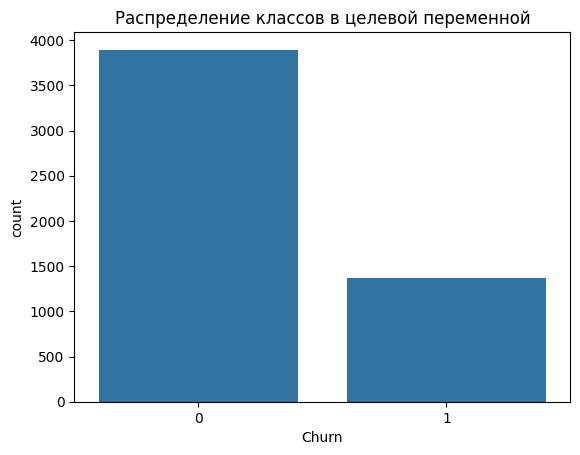

In [144]:
target_type = train['Churn'].dtype
print(f"Тип целевой переменной: {target_type}")

class_counts = train['Churn'].value_counts()
print("Распределение классов:")
print(class_counts)

sns.countplot(x='Churn', data=train)
plt.title('Распределение классов в целевой переменной')
plt.show()

Видно, что классы сильно разбалансированы. Применим балансировку с помощью метода resample.

Новое распределение классов после oversampling:
Churn
1    3894
0    3894
Name: count, dtype: int64


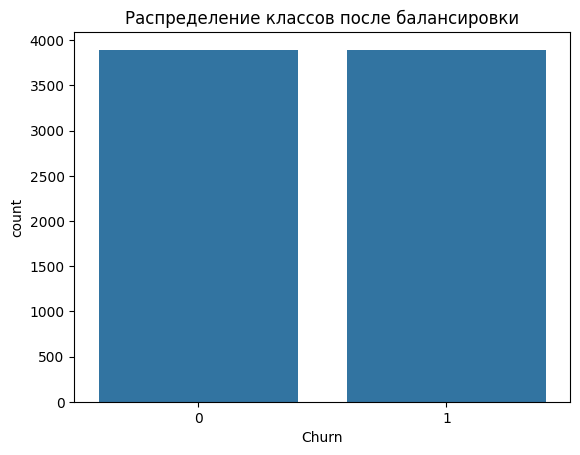

In [145]:
churn_date = train[train['Churn'] == 1]
not_churn_data = train[train['Churn'] == 0]

# Применяем oversampling для меньшего класса
data_sampled = resample(churn_date, 
                       replace=True,     # Случайное дублирование
                       n_samples=len(not_churn_data), # Уравнивание количества
                       random_state=42)  # Фиксируем random seed

# Объединение обратно в один набор данных
balanced_data = pd.concat([data_sampled, not_churn_data])

# Проверка нового распределения классов
print("Новое распределение классов после oversampling:")
print(balanced_data['Churn'].value_counts())

# Визуализация нового распределения
sns.countplot(x='Churn', data=balanced_data)
plt.title('Распределение классов после балансировки')
plt.show()

### Корелляционный анализ

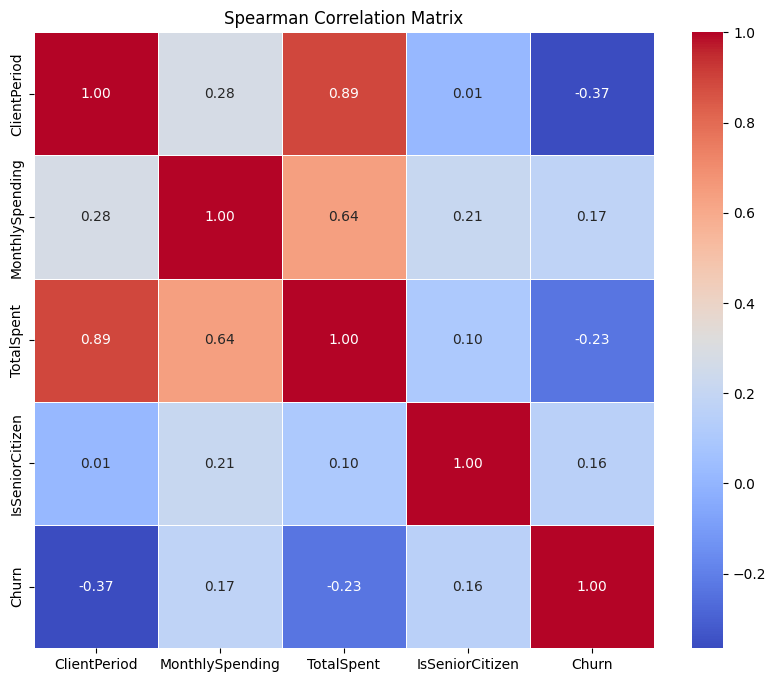

In [146]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])  # Выбираем числовые колонки

# Расчет матрицы корреляции методом Спирмена
corr_matrix = numerical_data.corr(method='spearman')

# Построение тепловой карты корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()

* Наиболее значимыми факторами, влияющими на вероятность оттока клиентов, являются ClientPeriod и TotalSpent. Чем дольше клиент пользуется услугами и чем больше он тратит, тем ниже вероятность его оттока.
* MonthlySpending и IsSeniorCitizen имеют слабую положительную корреляцию с оттоком, что требует дополнительного анализа, чтобы понять, как они влияют на поведение клиентов.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а.

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC.

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C).


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

### Кодировка признаков

In [152]:
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

### Разделение данных

In [154]:
X = train.drop(columns=['Churn'])
y = train['Churn']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

### Функция для построения roc_auc кривой и вычисления auc

In [162]:
def train_and_plot_roc(models, params, X_train, y_train, X_valid, y_valid):
    for model_name, model in models.items():
        print(f'Training {model_name}...')
        
        pipeline = make_pipeline(preprocessor, model)
        
        grid = GridSearchCV(pipeline, param_grid=params[model_name], cv=5, scoring='roc_auc', refit=True)
        
        grid.fit(X_train, y_train)
        
        best_model = grid.best_estimator_
        
        y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
        y_valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]
        
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
        fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)
        
        roc_auc_train = auc(fpr_train, tpr_train)
        roc_auc_valid = auc(fpr_valid, tpr_valid)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_train, tpr_train, lw=2, label=f'Train (area = {roc_auc_train:.2f})')
        plt.plot(fpr_valid, tpr_valid, lw=2, label=f'Valid (area = {roc_auc_valid:.2f})', linestyle='--')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()
        
        print(f"Best parameters for {model_name}: {grid.best_params_}")
        print(f"Best ROC-AUC (Validation) for {model_name}: {roc_auc_valid:.4f}")

### Обучение моделей

Training Logistic Regression...


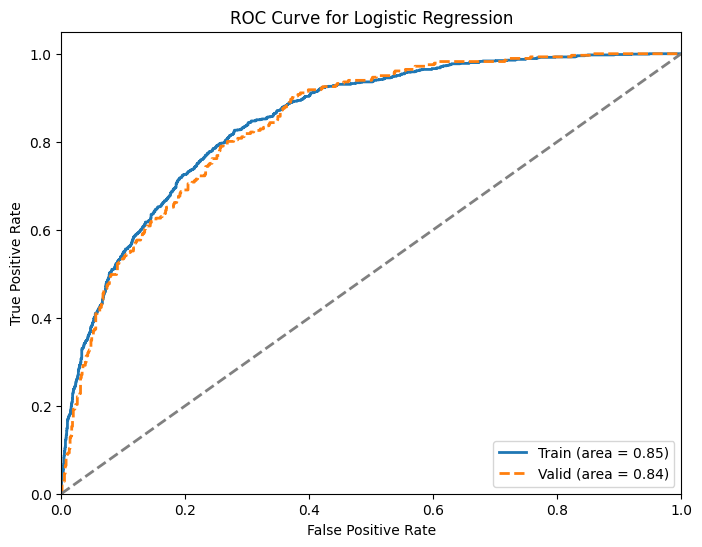

Best parameters for Logistic Regression: {'logisticregression__C': 10}
Best ROC-AUC (Validation) for Logistic Regression: 0.8432
Training CatBoost...


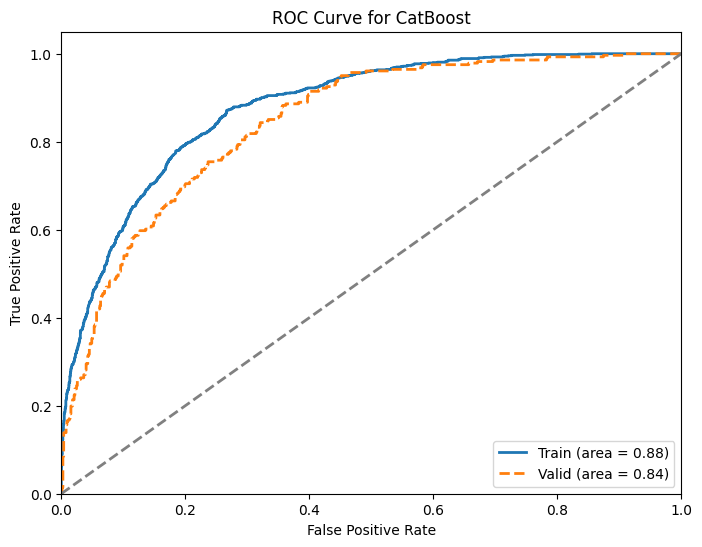

Best parameters for CatBoost: {'catboostclassifier__depth': 4, 'catboostclassifier__iterations': 100, 'catboostclassifier__learning_rate': 0.1}
Best ROC-AUC (Validation) for CatBoost: 0.8445
Training Random Forest...


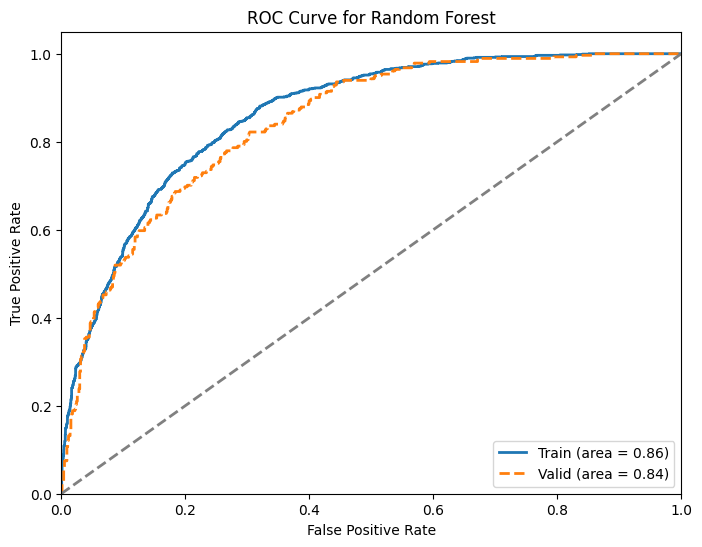

Best parameters for Random Forest: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 200}
Best ROC-AUC (Validation) for Random Forest: 0.8425


In [163]:
logreg_model = LogisticRegression(max_iter=1000)
catboost_model = CatBoostClassifier(verbose=0)
rf_model = RandomForestClassifier()

params = {
    'Logistic Regression': {
        'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'CatBoost': {
        'catboostclassifier__depth': [4, 6, 8],
        'catboostclassifier__iterations': [100, 200],
        'catboostclassifier__learning_rate': [0.01, 0.1]
    },
    'Random Forest': {
        'randomforestclassifier__n_estimators': [100, 200],
        'randomforestclassifier__max_depth': [5, 10, 20]
    }
}

models = {
    'Logistic Regression': logreg_model,
    'CatBoost': catboost_model,
    'Random Forest': rf_model
}

train_and_plot_roc(models, params, X_train, y_train, X_valid, y_valid)

### Оценка моделей

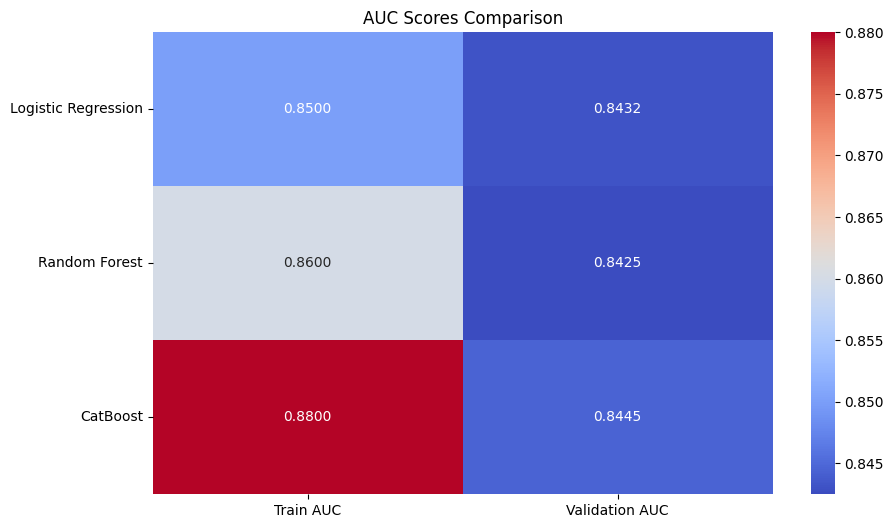

In [166]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'CatBoost'],
    'train AUC': [0.85, 0.86, 0.88],  
    'valid AUC': [0.8432, 0.8425, 0.8445] 
})

plt.figure(figsize=(10, 6))
sns.heatmap(results[['train AUC', 'valid AUC']], annot=True, cmap='coolwarm', fmt='.4f', cbar=True)

plt.title('AUC Scores Comparison')
plt.xticks(ticks=[0.5, 1.5], labels=['Train AUC', 'Validation AUC'], rotation=0)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=results['Model'], rotation=0)
plt.show()

**Лучшей моделью является CatBoost**
* Best parameters for CatBoost: {'catboostclassifier__depth': 4, 'catboostclassifier__iterations': 100, 'catboostclassifier__learning_rate': 0.1}
* Best ROC-AUC (Validation) for CatBoost: 0.8445

# Предсказания

In [171]:
best_model = CatBoostClassifier(verbose=0, depth=4, iterations=100, learning_rate=0.1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = make_pipeline(preprocessor, best_model)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_valid)

In [177]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')
X_test_preprocessed = preprocessor.transform(test)

submission['Churn'] = best_model.predict_proba(X_test_preprocessed)[:, 1]
submission.to_csv('./my_submission.csv')

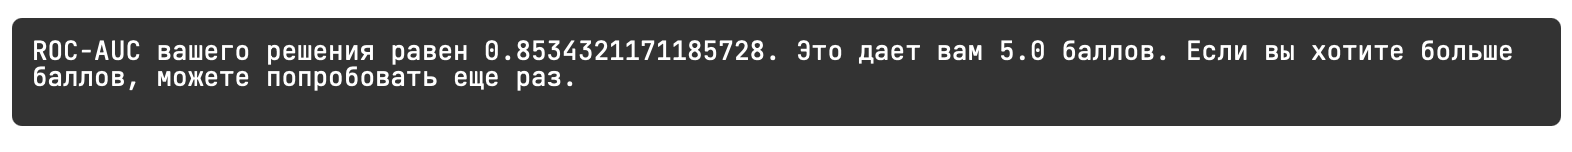